In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
data_22 = pd.read_csv('data/pl21-22.csv')
data_23 = pd.read_csv('data/pl22-23.csv')
data_24 = pd.read_csv('data/pl23-24.csv')
data_25 = pd.read_csv('data/pl24-25.csv')
data_26 = pd.read_csv('data/pl25-26.csv')

In [26]:
data_22["GapToLeader"] = data_22["Pts"] - data_22["Pts"].max()
data_23["GapToLeader"] = data_23["Pts"] - data_23["Pts"].max()
data_24["GapToLeader"] = data_24["Pts"] - data_24["Pts"].max()
data_25["GapToLeader"] = data_25["Pts"] - data_25["Pts"].max()
data_26["GapToLeader"] = data_26["Pts"] - data_26["Pts"].max()

In [27]:
full_data = pd.concat([data_22,data_23,data_24,data_25,data_26], ignore_index=True)
full_data = full_data.drop(columns=['TeamID','last_5_winners'])
full_data.describe()

,GoalsForHome,GoalsAgainstHome,GoalsForAway,GoalsAgainstAway,WinsHome,DrawsHome,LossesHome,WinsAway,DrawsAway,LossesAway,...,Losses,Pts,Pts/MP,xG,xGA,xGD,xGD/90,Rank,Rating,GapToLeader
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,80.00000,80.000000,80.000000,...,100.000000,100.000000,80.000000,80.000000,80.00000,80.000000,8.000000e+01,100.000000,79.000000,100.000000
mean,30.687500,25.762500,25.762500,30.687500,8.462500,4.375000,6.16250,6.16250,4.375000,8.462500,...,11.770000,42.250000,1.381125,54.390000,54.38625,-0.005000,5.551115e-18,10.500000,6.904937,-29.750000
std,10.776902,8.768822,8.024084,8.689574,3.778499,1.905189,3.61937,3.07066,1.752936,3.260596,...,8.082723,26.565861,0.495468,14.102963,11.85348,23.667982,6.233007e-01,5.795331,0.123412,22.168489
min,12.000000,9.000000,11.000000,11.000000,1.000000,0.000000,0.00000,1.00000,1.000000,1.000000,...,0.000000,0.000000,0.320000,32.300000,24.60000,-52.100000,-1.370000e+00,1.000000,6.670000,-75.000000
25%,23.000000,19.750000,19.750000,25.000000,6.000000,3.000000,3.75000,4.00000,3.000000,7.000000,...,4.000000,23.750000,1.045000,44.300000,48.00000,-17.400000,-4.600000e-01,5.750000,6.825000,-46.250000
50%,29.000000,25.000000,25.000000,31.000000,8.000000,4.000000,6.00000,6.00000,4.000000,9.000000,...,12.000000,45.500000,1.340000,51.100000,54.20000,-2.200000,-6.000000e-02,10.500000,6.900000,-30.000000
75%,37.000000,29.000000,29.500000,37.000000,11.250000,6.000000,8.25000,8.00000,5.000000,10.250000,...,18.000000,61.000000,1.740000,63.325000,63.00000,15.050000,3.950000e-01,15.250000,6.960000,-3.000000
max,60.000000,57.000000,45.000000,48.000000,17.000000,9.000000,15.00000,14.00000,9.000000,15.000000,...,30.000000,93.000000,2.450000,88.700000,84.80000,64.000000,1.680000e+00,20.000000,7.310000,0.000000


In [28]:
teams = full_data['Team'].unique()
teams_dict = {team: i+1 for i, team in enumerate(teams)}
full_data["Team"] = full_data["Team"].map(teams_dict)
teams_dict

{'Brentford': 1,
 'Man United': 2,
 'Burnley': 3,
 'Chelsea': 4,
 'Everton': 5,
 'Leicester': 6,
 'Watford': 7,
 'Norwich': 8,
 'Newcastle': 9,
 'Tottenham': 10,
 'Liverpool': 11,
 'Aston Villa': 12,
 'Crystal Palace': 13,
 'Leeds': 14,
 'Man City': 15,
 'Brighton': 16,
 'Southampton': 17,
 'Wolves': 18,
 'Arsenal': 19,
 'West Ham': 20,
 'Fulham': 21,
 'Bournemouth': 22,
 "Nott'm Forest": 23,
 'Sheffield United': 24,
 'Luton': 25,
 'Ipswich': 26,
 'Sunderland': 27}

In [29]:
full_data.describe()

,Team,GoalsForHome,GoalsAgainstHome,GoalsForAway,GoalsAgainstAway,WinsHome,DrawsHome,LossesHome,WinsAway,DrawsAway,...,Losses,Pts,Pts/MP,xG,xGA,xGD,xGD/90,Rank,Rating,GapToLeader
count,100.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,80.00000,80.000000,...,100.000000,100.000000,80.000000,80.000000,80.00000,80.000000,8.000000e+01,100.000000,79.000000,100.000000
mean,12.76000,30.687500,25.762500,25.762500,30.687500,8.462500,4.375000,6.16250,6.16250,4.375000,...,11.770000,42.250000,1.381125,54.390000,54.38625,-0.005000,5.551115e-18,10.500000,6.904937,-29.750000
std,7.09121,10.776902,8.768822,8.024084,8.689574,3.778499,1.905189,3.61937,3.07066,1.752936,...,8.082723,26.565861,0.495468,14.102963,11.85348,23.667982,6.233007e-01,5.795331,0.123412,22.168489
min,1.00000,12.000000,9.000000,11.000000,11.000000,1.000000,0.000000,0.00000,1.00000,1.000000,...,0.000000,0.000000,0.320000,32.300000,24.60000,-52.100000,-1.370000e+00,1.000000,6.670000,-75.000000
25%,6.00000,23.000000,19.750000,19.750000,25.000000,6.000000,3.000000,3.75000,4.00000,3.000000,...,4.000000,23.750000,1.045000,44.300000,48.00000,-17.400000,-4.600000e-01,5.750000,6.825000,-46.250000
50%,13.00000,29.000000,25.000000,25.000000,31.000000,8.000000,4.000000,6.00000,6.00000,4.000000,...,12.000000,45.500000,1.340000,51.100000,54.20000,-2.200000,-6.000000e-02,10.500000,6.900000,-30.000000
75%,19.00000,37.000000,29.000000,29.500000,37.000000,11.250000,6.000000,8.25000,8.00000,5.000000,...,18.000000,61.000000,1.740000,63.325000,63.00000,15.050000,3.950000e-01,15.250000,6.960000,-3.000000
max,27.00000,60.000000,57.000000,45.000000,48.000000,17.000000,9.000000,15.00000,14.00000,9.000000,...,30.000000,93.000000,2.450000,88.700000,84.80000,64.000000,1.680000e+00,20.000000,7.310000,0.000000


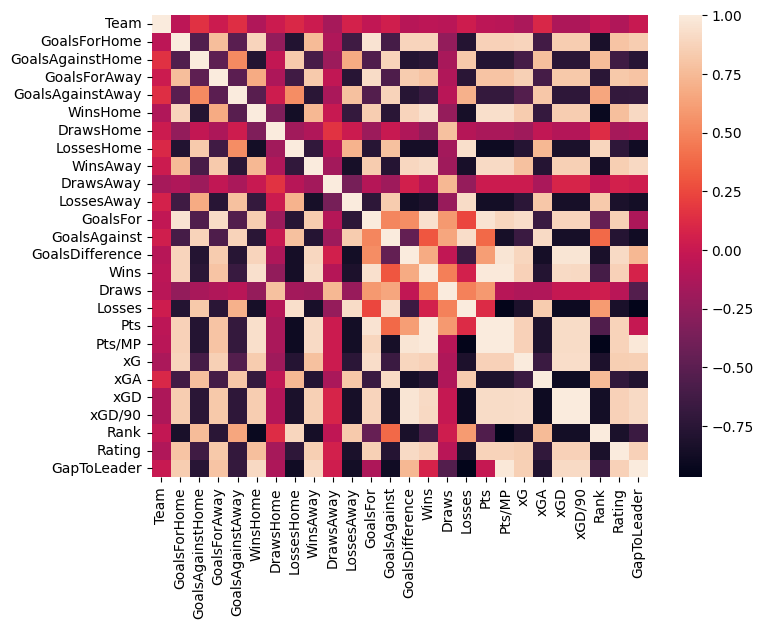

In [30]:
# Assuming 'df' is your DataFrame
corr_df = full_data.corr(method="pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df)
plt.show()

In [ ]:
data_22_corr = data_22.drop(columns=['TeamID', 'Team', 'xGD', 'xGD/90','GoalsForHome', 'GoalsAgainstHome', 'GoalsForAway', 'GoalsAgainstAway', 'WinsHome', 'WinsAway', 'LossesHome', 'LossesAway', 'DrawsHome', 'DrawsAway', 'Pts/MP'])

data_23_corr = data_23.drop(columns=['TeamID', 'Team', 'last_5_winners', 'xGD', 'xGD/90','GoalsForHome', 'GoalsAgainstHome', 'GoalsForAway', 'GoalsAgainstAway', 'WinsHome', 'WinsAway', 'LossesHome', 'LossesAway', 'DrawsHome', 'DrawsAway', 'Pts/MP'])

data_24_corr = data_24.drop(columns=['TeamID', 'Team', 'last_5_winners', 'xGD', 'xGD/90','GoalsForHome', 'GoalsAgainstHome', 'GoalsForAway', 'GoalsAgainstAway', 'WinsHome', 'WinsAway', 'LossesHome', 'LossesAway', 'DrawsHome', 'DrawsAway', 'Pts/MP'])

data_25_corr = data_25.drop(columns=['TeamID', 'Team', 'last_5_winners', 'xGD', 'xGD/90','GoalsForHome', 'GoalsAgainstHome', 'GoalsForAway', 'GoalsAgainstAway', 'WinsHome', 'WinsAway', 'LossesHome', 'LossesAway', 'DrawsHome', 'DrawsAway', 'Pts/MP'])

data_26_corr = data_26.drop(columns=['Team'])

In [ ]:
'''data_22_corr = data_22.drop(columns=['TeamID', 'Team'])

data_23_corr = data_23.drop(columns=['TeamID', 'Team', 'last_5_winners'])

data_24_corr = data_24.drop(columns=['TeamID', 'Team', 'last_5_winners'])

data_25_corr = data_25.drop(columns=['TeamID', 'Team', 'last_5_winners'])'''

In [32]:
data_25_corr.columns

Index(['GoalsFor', 'GoalsAgainst', 'GoalsDifference', 'Wins', 'Draws',
       'Losses', 'Pts', 'Rank', 'GapToLeader'],
      dtype='object')

In [33]:
data_26_corr.columns

Index(['GoalsFor', 'GoalsAgainst', 'GoalsDifference', 'Wins', 'Draws',
       'Losses', 'Pts', 'Rank', 'GapToLeader'],
      dtype='object')

In [34]:
# Concatenate training data from 23 and 24 seasons
X_train = pd.concat([data_22_corr, data_23_corr, data_24_corr, data_25_corr], ignore_index=True)
X_train = X_train.drop(columns=['Rank'])

# Prepare test data from 25 season (drop target column)
X_test = data_26_corr.drop(columns=['Rank'])

# Concatenate training labels from 23 and 24 seasons
y_train = pd.concat([data_22_corr["Rank"], data_23_corr["Rank"], data_24_corr["Rank"], data_25_corr["Rank"]], ignore_index=True)

# Test labels from 25 season
y_test = data_26_corr["Rank"]


In [35]:
model = xgb.XGBRegressor(
    max_depth=4,
    n_estimators=200,
    random_state=42
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [36]:
predicted_ranks = model.predict(X_test)

In [37]:
# Invert ranks to "scores" (higher score = better chance)
inv_ranks = 1 / predicted_ranks

# Normalize to get probabilities summing to 1
win_probs = inv_ranks / np.sum(inv_ranks)

# Add to test dataframe for review
result = data_25.copy()
result['PL_Champions'] = win_probs *100
ranks = np.arange(1,len(y_test)+1)
result = result.sort_values(by='PL_Champions', ascending=False)
result['PL_Champions'] = result['PL_Champions'].round(2).astype(str) + '%'
result['Predicted_Rank'] = ranks

print(result[['Team','PL_Champions', 'Predicted_Rank']])

              Team PL_Champions  Predicted_Rank
0       Man United        5.05%               1
1          Ipswich        5.05%               2
2          Arsenal        5.05%               3
3          Everton        5.05%               4
4        Newcastle        5.05%               5
5    Nott'm Forest        5.05%               6
6         West Ham        5.05%               7
7        Brentford        4.97%               8
8          Chelsea        4.97%               9
9        Leicester        4.97%              10
10        Brighton        4.97%              11
11  Crystal Palace        4.97%              12
12          Fulham        4.97%              13
13        Man City        4.97%              14
14     Southampton        4.97%              15
15       Tottenham        4.97%              16
16     Aston Villa        4.97%              17
17     Bournemouth        4.97%              18
18          Wolves        4.97%              19
19       Liverpool        4.97%         

In [38]:
for col in X_train.columns:
    print(f"{col}: {model.feature_importances_[X_train.columns.get_loc(col)]}")

GoalsFor: 0.0013648825697600842
GoalsAgainst: 0.0010939707281067967
GoalsDifference: 0.02904202975332737
Wins: 0.20195545256137848
Draws: 0.0018202742794528604
Losses: 0.006808382924646139
Pts: 0.7489328980445862
GapToLeader: 0.008982144296169281


In [39]:
probs = result[['Team', 'PL_Champions', 'Predicted_Rank']]
probs

,Team,PL_Champions,Predicted_Rank
0,Man United,5.05%,1
1,Ipswich,5.05%,2
2,Arsenal,5.05%,3
3,Everton,5.05%,4
4,Newcastle,5.05%,5
5,Nott'm Forest,5.05%,6
6,West Ham,5.05%,7
7,Brentford,4.97%,8
8,Chelsea,4.97%,9
9,Leicester,4.97%,10


In [40]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predicted_ranks.round())
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.05
